In [3]:
# import packages

import numpy as np
from numpy import linspace
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

Before you start designing the detection techniques, make sure you have all needed features (`sentence scores`, `laser scores`, `alti scores`, and the `annotations`)

- Please, refer to this [Readme](https://github.com/andreniyongabo/hallucination_detection_and_mitigation/blob/main/README.md) file to see step by step on how to get these features needed for hallucination detection design and mitigation.

- And refer to [this file](https://docs.google.com/spreadsheets/d/1QGTc-H5-hXnh3W1dbaVQq5xn25jFO9fmypcmE67buho/edit#gid=0) to see the detailed annotations

In [14]:
# paths to data files and directories
src = "eng"
tgt = "kin"
flores_first_100_data_path = f"translations/flores_test/{src}-{tgt}/data_for_eval_100.csv"

# vizualizing the data
df = pd.read_csv(flores_first_100_data_path)
df.head()

,eng,kin,sent_score,laser_score,alti_score,annotation
0,"""We now have 4-month-old mice that are non-dia...","Yongeyeho ati ""ubu dufite impene z'amezi ane z...",-0.844550,0.784786,0.444763,WW
1,"Dr. Ehud Ur, professor of medicine at Dalhousi...","Dr. Ehud Ur, umwarimu wigisha ibijyanye n'ubuv...",-0.688445,0.931296,0.405180,WW
2,"Like some other experts, he is skeptical about...","Kimwe n'abandi bahanga bamwe na bamwe, na we n...",-0.938590,0.856047,0.432933,NT
3,"On Monday, Sara Danius, permanent secretary of...","Ku wa mbere, Sara Danius, umunyamabanga w'igih...",-0.831531,0.932948,0.359460,NT
4,"Danius said, ""Right now we are doing nothing. ...","Danius yagize ati "" Kugeza ubu nta kintu na ki...",-1.160723,0.886903,0.452443,WW


In [15]:
# prepare the data
# we are interested in full sentence hallucinations and natural/correct translations, so we discard the wrong words (WW)
cond = df["annotation"]=="WW"
cond_hl = (df["annotation"]=="DH") | (df["annotation"]=="OH") | (df["annotation"]=="EH") | (df["annotation"]=="SH")
cond_nt = df["annotation"]=="NT"

df.loc[cond,"annotation"]="WW"
df.loc[cond_hl,"annotation"]="hallucination"
df.loc[cond_nt,"annotation"]="natural translation"

df_new = df[df["annotation"]!="WW"]   
    
df_new = df_new.reset_index(drop=True)
df_new.head()

,eng,kin,sent_score,laser_score,alti_score,annotation
0,"Like some other experts, he is skeptical about...","Kimwe n'abandi bahanga bamwe na bamwe, na we n...",-0.938590,0.856047,0.432933,natural translation
1,"On Monday, Sara Danius, permanent secretary of...","Ku wa mbere, Sara Danius, umunyamabanga w'igih...",-0.831531,0.932948,0.359460,natural translation
2,Siminoff said sales boosted after his 2013 app...,Siminoff yavuze ko ibicuruzwa byazamutse nyuma...,-0.724982,0.886111,0.515889,hallucination
3,"In late 2017, Siminoff appeared on shopping te...","Mu mpera z'umwaka wa 2017, Siminoff yagaragaye...",-0.565374,0.890373,0.525525,natural translation
4,Ring also settled a lawsuit with competing sec...,Ring kandi yageze ku masezerano y'urukiko n'ik...,-1.006676,0.835080,0.410035,natural translation


sent_score_avg: -0.848294845992519

 f1_score: 0.5777777777777777 precision_score: 0.48148148148148145 recall_score: 0.7222222222222222


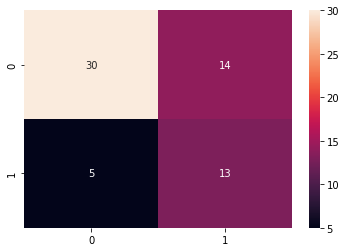

In [23]:
# detection based on sentence scores average

def sent_score_based_detection(df):
    #halluc=1
    #natural_trans=0

    scores_nt = [df.sent_score[i] for i in range(len(df))] 
    avg_score = np.array(scores_nt).sum()/len(scores_nt)
    print("sent_score_avg:", avg_score)

    orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])] # assign 1 to hallucination and 0 to natural translations
    pred_classes = []

    for i,score in enumerate(df["sent_score"]):
        if score <= avg_score:
            pred_classes.append(1)
        else:
            pred_classes.append(0)
    
    
#     # check false positives
#     print("false positives")
#     for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
#         print(df["kin"][j]) 
        
#     print("--"*50)
    
#     # check false negatives
#     print("false negatives")
#     for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
#         print(df["kin"][j])

    f_score = f1_score(np.array(orig_classes), np.array(pred_classes))
    p_score = precision_score(np.array(orig_classes), np.array(pred_classes))
    r_score = recall_score(np.array(orig_classes), np.array(pred_classes))
    conf_matrix = confusion_matrix(orig_classes, pred_classes)
    
    return f_score, p_score, r_score, conf_matrix
    
f_score, p_score, r_score, conf_matrix = sent_score_based_detection(df_new)
print("\n", "f1_score:", f_score, "precision_score:", p_score, "recall_score:", r_score)

sns.heatmap(conf_matrix, annot=True)
# plt.savefig("annotation/avg_sent_score-based.png",
#                      format='png',dpi=150)
plt.show()


laser_score_avg 0.8663305809677417

 f1_score: 0.5333333333333333 precision_score: 0.4444444444444444 recall_score: 0.6666666666666666


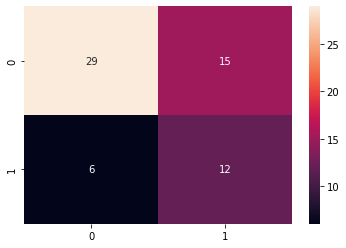

In [25]:
# detection based on laser scores average

def laser_score_based_detection(df):
    #halluc=1
    #natural_trans=0
    
    scores_nt = [df.laser_score[i] for i in range(len(df))] 
    avg_score = np.array(scores_nt).sum()/len(scores_nt)
    print("laser_score_avg", avg_score)

    orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])] # assign 1 to hallucination and 0 to natural translations
    pred_classes = []

    for i, score in enumerate(df["laser_score"]):
        if score <= avg_score:
            pred_classes.append(1)
        else:
            pred_classes.append(0)
    
    
#     # check false positives
#     print("false positives")
#     for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
#         print(df["kin"][j]) 
        
#     print("--"*50)
    
#     # check false negatives
#     print("false negatives")
#     for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
#         print(df["kin"][j])

    f_score = f1_score(np.array(orig_classes), np.array(pred_classes))
    p_score = precision_score(np.array(orig_classes), np.array(pred_classes))
    r_score = recall_score(np.array(orig_classes), np.array(pred_classes))
    conf_matrix = confusion_matrix(orig_classes, pred_classes)
    
    return f_score, p_score, r_score, conf_matrix
    
f_score, p_score, r_score, conf_matrix = laser_score_based_detection(df_new)
print("\n", "f1_score:", f_score, "precision_score:", p_score, "recall_score:", r_score)

sns.heatmap(conf_matrix, annot=True)
# plt.savefig("annotation/avg_sent_score-based.png",
#                      format='png',dpi=150)
plt.show()


 f1_score: 0.0 precision_score: 0.0 recall_score: 0.0


/public/apps/anaconda3/2021.05/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


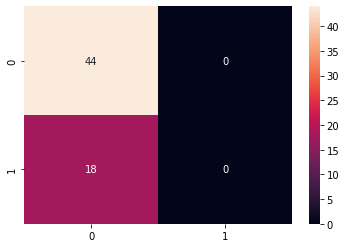

In [41]:
# detection based on alti scores threshold

def alti_score_based_detection(df, alti_threshold):
    #halluc=1
    #natural_trans=0

    orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])] # assign 1 to hallucination and 0 to natural translations
    pred_classes = []

    for i, score in enumerate(df["alti_score"]):
        if score <= alti_threshold:
            pred_classes.append(1)
        else:
            pred_classes.append(0)
    
    
#     # check false positives
#     print("false positives")
#     for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
#         print(df["kin"][j]) 
        
#     print("--"*50)
    
#     # check false negatives
#     print("false negatives")
#     for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
#         print(df["kin"][j])

    f_score = f1_score(np.array(orig_classes), np.array(pred_classes))
    p_score = precision_score(np.array(orig_classes), np.array(pred_classes))
    r_score = recall_score(np.array(orig_classes), np.array(pred_classes))
    conf_matrix = confusion_matrix(orig_classes, pred_classes)
    
    return f_score, p_score, r_score, conf_matrix
    
f_score, p_score, r_score, conf_matrix = alti_score_based_detection(df_new, alti_threshold)
print("\n", "f1_score:", f_score, "precision_score:", p_score, "recall_score:", r_score)

sns.heatmap(conf_matrix, annot=True)
# plt.savefig("annotation/avg_sent_score-based.png",
#                      format='png',dpi=150)
plt.show()

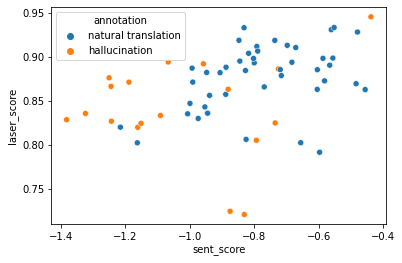

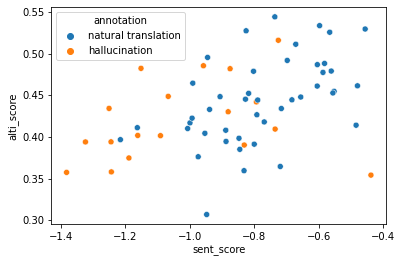

In [43]:
sns.scatterplot(data=df_new, x="sent_score", y="laser_score", hue="annotation")
# plt.savefig("annotation/sent_sim_correlation.png",
#                      format='png',dpi=150)
plt.show()

sns.scatterplot(data=df_new, x="sent_score", y="alti_score", hue="annotation")
# plt.savefig("annotation/sent_sim_correlation.png",
#                      format='png',dpi=150)
plt.show()

sent_avg_score: -0.848294845992519 laser_avg_score: 0.8663305809677417
false positives
Siminoff yavuze ko ibicuruzwa byazamutse nyuma yo kugaragara mu mwaka wa 2013 mu gice cya Shark Tank aho abagenzuzi b'igitaramo banze gutanga inkunga yo gutangira.
Ishyirahamwe ry'imikino ya Gymnastics muri Leta Zunze Ubumwe z'Amerika (USA Gymnastics) n'Ishyirahamwe ry'imikino ya Olympic muri Amerika (USOC) bifite intego imwe, ni ukuvuga gutuma imikino y'imikino ya Gymnastics n'indi mikino itari iy'imikino itari iy'imikino itari iy'imikino itari iy'imikino itari iy'imikino itari iy'imikino itari iy'imikino itari iy'imikino itari iy'imikino.
Ibindi bihembo birimo Best Picture, Director, Cinematography, Costume Design, Film-editing, Original Score, Production Design, Sound Editing, Sound Mixing na Original Screenplay.
Abashakashatsi bavuze ko n'ubwo uwo ari umurizo w'inyamaswa yitwa dinosaure yari ikiri muto, uwo muco ugaragaza amababa y'umuntu mukuru, aho kugaragaza amababa y'umwana.
Basanze izuba rik

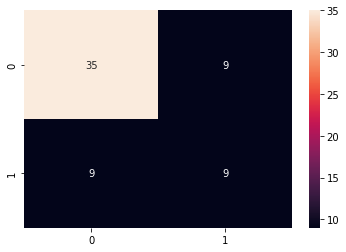

In [27]:
# detection based on both sentence scores average and laser scores average

def sent_laser_AND_based_detection(df):
    #halluc=1
    #natural_trans=0

    sent_scores_nt = [df.sent_score[i] for i in range(len(df))] 
    sent_avg_score = np.array(sent_scores_nt).sum()/len(sent_scores_nt)

    laser_scores_nt = [df.laser_score[i] for i in range(len(df))] # if df.annotation[i]=="natural translation"
    laser_avg_score = np.array(laser_scores_nt).sum()/len(laser_scores_nt)

    print("sent_avg_score:", sent_avg_score, "laser_avg_score:", laser_avg_score)

    orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])]
    pred_classes = []

    for i in range(len(df)):
        if df["laser_score"][i] <= laser_avg_score and df["sent_score"][i] <= sent_avg_score:
            pred_classes.append(1)
        else:
            pred_classes.append(0)

    # check false positives
    print("false positives")
    for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
        print(df["kin"][j]) 

    print("--"*50)

    # check false negatives
    print("false negatives")
    for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
        print(df["kin"][j])

    f_score = f1_score(np.array(orig_classes), np.array(pred_classes))
    p_score = precision_score(np.array(orig_classes), np.array(pred_classes))
    r_score = recall_score(np.array(orig_classes), np.array(pred_classes))
    conf_matrix = confusion_matrix(orig_classes, pred_classes)
        
    return f_score, p_score, r_score, conf_matrix

f_score, p_score, r_score, conf_matrix = sent_laser_AND_based_detection(df_new)
print("\n", "f1_score:", f_score, "precision_score:", p_score, "recall_score:", r_score)

sns.heatmap(conf_matrix, annot=True)
# plt.savefig("annotation/sent_sim_correlation-and.png",
#                      format='png',dpi=150)
plt.show()

sent_avg_score: -0.848294845992519 laser_avg_score: 0.8663305809677417
false positives
Siminoff yavuze ko ibicuruzwa byazamutse nyuma yo kugaragara mu mwaka wa 2013 mu gice cya Shark Tank aho abagenzuzi b'igitaramo banze gutanga inkunga yo gutangira.
Ibindi bihembo birimo Best Picture, Director, Cinematography, Costume Design, Film-editing, Original Score, Production Design, Sound Editing, Sound Mixing na Original Screenplay.
----------------------------------------------------------------------------------------------------
false negatives
Kimwe n'abandi bahanga bamwe na bamwe, na we ntiyemera ko indwara ya diyabete ishobora gukira, kandi avuga ko ibyo bashyize ahagaragara bitagira icyo bimariye abantu bafite indwara ya diyabete yo mu bwoko bwa 1.
Ring kandi yageze ku masezerano y'urukiko n'ikigo cy'umutekano cya ADT Corporation.
N'ubwo urukingo rumwe rukiri mu igeragezwa rwerekana ko rushobora kugabanya umubare w'abahitanwa na Ebola, kugeza ubu, nta miti yagaragaye neza ko ikwiriye k

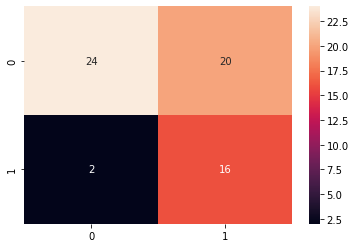

In [28]:
# detection based on both sentence scores average and laser scores average

def sent_laser_OR_based_detection(df):
    #halluc=1
    #natural_trans=0

    sent_scores_nt = [df.sent_score[i] for i in range(len(df))] 
    sent_avg_score = np.array(sent_scores_nt).sum()/len(sent_scores_nt)

    laser_scores_nt = [df.laser_score[i] for i in range(len(df))] # if df.annotation[i]=="natural translation"
    laser_avg_score = np.array(laser_scores_nt).sum()/len(laser_scores_nt)

    print("sent_avg_score:", sent_avg_score, "laser_avg_score:", laser_avg_score)

    orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])]
    pred_classes = []

    for i in range(len(df)):
        if df["laser_score"][i] <= laser_avg_score or df["sent_score"][i] <= sent_avg_score:
            pred_classes.append(1)
        else:
            pred_classes.append(0)

    # check false positives
    print("false positives")
    for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
        print(df["kin"][j]) 

    print("--"*50)

    # check false negatives
    print("false negatives")
    for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
        print(df["kin"][j])

    f_score = f1_score(np.array(orig_classes), np.array(pred_classes))
    p_score = precision_score(np.array(orig_classes), np.array(pred_classes))
    r_score = recall_score(np.array(orig_classes), np.array(pred_classes))
    conf_matrix = confusion_matrix(orig_classes, pred_classes)
        
    return f_score, p_score, r_score, conf_matrix

f_score, p_score, r_score, conf_matrix = sent_laser_OR_based_detection(df_new)
print("\n", "f1_score:", f_score, "precision_score:", p_score, "recall_score:", r_score)

sns.heatmap(conf_matrix, annot=True)
# plt.savefig("annotation/sent_sim_correlation-and.png",
#                      format='png',dpi=150)
plt.show()

sent_laser_avg: 0.01803573497522292
false positives
Siminoff yavuze ko ibicuruzwa byazamutse nyuma yo kugaragara mu mwaka wa 2013 mu gice cya Shark Tank aho abagenzuzi b'igitaramo banze gutanga inkunga yo gutangira.
Ibindi bihembo birimo Best Picture, Director, Cinematography, Costume Design, Film-editing, Original Score, Production Design, Sound Editing, Sound Mixing na Original Screenplay.
Ntiyatangaje umubare w'abazacibwa, avuga ko bazacibwa hashingiwe ku iterambere ry'ubukungu bw'Ubushinwa.
----------------------------------------------------------------------------------------------------
false negatives
Kimwe n'abandi bahanga bamwe na bamwe, na we ntiyemera ko indwara ya diyabete ishobora gukira, kandi avuga ko ibyo bashyize ahagaragara bitagira icyo bimariye abantu bafite indwara ya diyabete yo mu bwoko bwa 1.
Ring kandi yageze ku masezerano y'urukiko n'ikigo cy'umutekano cya ADT Corporation.
N'ubwo urukingo rumwe rukiri mu igeragezwa rwerekana ko rushobora kugabanya umubare w'a

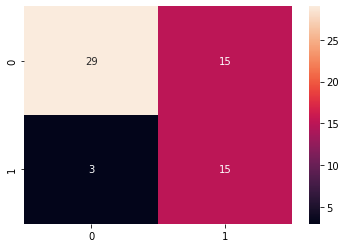

In [30]:
# detection based on both sentence scores average and laser scores average

def sent_laser_AVG_based_detection(df):
    #halluc=1
    #natural_trans=0

    sent_laser_scores = [df.sent_score[i]+df.laser_score[i] for i in range(len(df))] # if df.annotation[i]=="natural translation"
    sent_laser_avg = np.array(sent_laser_scores).sum()/len(sent_laser_scores)
    print("sent_laser_avg:", sent_laser_avg)

    orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])]
    pred_classes = []

    for i in range(len(df)):
        if df["laser_score"][i]+df["sent_score"][i] <= sent_laser_avg:
            pred_classes.append(1)
        else:
            pred_classes.append(0)

    # check false positives
    print("false positives")
    for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
        print(df["kin"][j]) 

    print("--"*50)

    # check false negatives
    print("false negatives")
    for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
        print(df["kin"][j])

    f_score = f1_score(np.array(orig_classes), np.array(pred_classes))
    p_score = precision_score(np.array(orig_classes), np.array(pred_classes))
    r_score = recall_score(np.array(orig_classes), np.array(pred_classes))
    conf_matrix = confusion_matrix(orig_classes, pred_classes)
        
    return f_score, p_score, r_score, conf_matrix

f_score, p_score, r_score, conf_matrix = sent_laser_AVG_based_detection(df_new)
print("\n", "f1_score:", f_score, "precision_score:", p_score, "recall_score:", r_score)
 
sns.heatmap(conf_matrix, annot=True)
# plt.savefig("annotation/sent_sim_correlation-and.png",
#                      format='png',dpi=150)
plt.show()

sent_laser_avg: 0.01803573497522292
false positives
Siminoff yavuze ko ibicuruzwa byazamutse nyuma yo kugaragara mu mwaka wa 2013 mu gice cya Shark Tank aho abagenzuzi b'igitaramo banze gutanga inkunga yo gutangira.
Ibindi bihembo birimo Best Picture, Director, Cinematography, Costume Design, Film-editing, Original Score, Production Design, Sound Editing, Sound Mixing na Original Screenplay.
Ntiyatangaje umubare w'abazacibwa, avuga ko bazacibwa hashingiwe ku iterambere ry'ubukungu bw'Ubushinwa.
----------------------------------------------------------------------------------------------------
false negatives
Kimwe n'abandi bahanga bamwe na bamwe, na we ntiyemera ko indwara ya diyabete ishobora gukira, kandi avuga ko ibyo bashyize ahagaragara bitagira icyo bimariye abantu bafite indwara ya diyabete yo mu bwoko bwa 1.
Ring kandi yageze ku masezerano y'urukiko n'ikigo cy'umutekano cya ADT Corporation.
N'ubwo urukingo rumwe rukiri mu igeragezwa rwerekana ko rushobora kugabanya umubare w'a

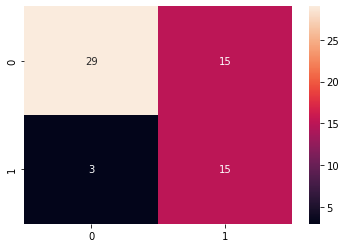

In [34]:
# detection based on both sentence scores average, laser scores average, and alti scores average

def sent_laser_alti_based_detection(df, alti_threshold):
    #halluc=1
    #natural_trans=0

    sent_laser_scores = [df.sent_score[i]+df.laser_score[i] for i in range(len(df))] # if df.annotation[i]=="natural translation"
    sent_laser_avg = np.array(sent_laser_scores).sum()/len(sent_laser_scores)
    print("sent_laser_avg:", sent_laser_avg)

    orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])]
    pred_classes = []

    for i in range(len(df)):
        if (df["laser_score"][i]+df["sent_score"][i]) <= sent_laser_avg or df["alti_score"][i] <= alti_threshold:
            pred_classes.append(1)
        else:
            pred_classes.append(0)

    # check false positives
    print("false positives")
    for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
        print(df["kin"][j]) 

    print("--"*50)

    # check false negatives
    print("false negatives")
    for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
        print(df["kin"][j])

    f_score = f1_score(np.array(orig_classes), np.array(pred_classes))
    p_score = precision_score(np.array(orig_classes), np.array(pred_classes))
    r_score = recall_score(np.array(orig_classes), np.array(pred_classes))
    conf_matrix = confusion_matrix(orig_classes, pred_classes)
        
    return f_score, p_score, r_score, conf_matrix

alti_threshold = 0.3
f_score, p_score, r_score, conf_matrix = sent_laser_alti_based_detection(df_new, alti_threshold)
print("\n", "f1_score:", f_score, "precision_score:", p_score, "recall_score:", r_score)
 
sns.heatmap(conf_matrix, annot=True)
# plt.savefig("annotation/sent_sim_correlation-and.png",
#                      format='png',dpi=150)
plt.show()

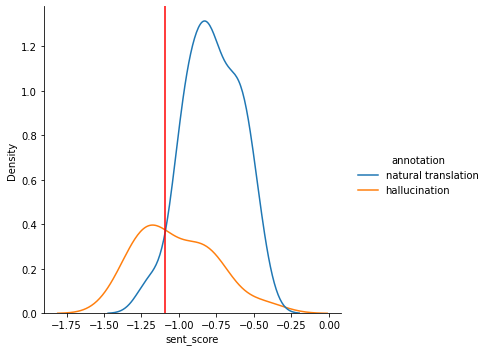

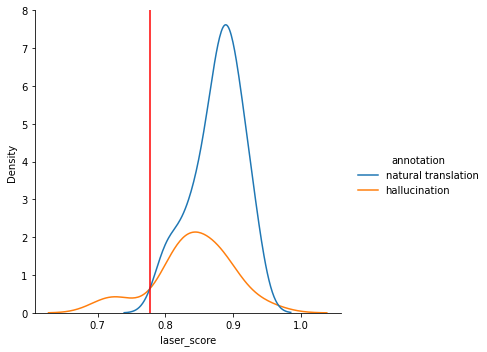

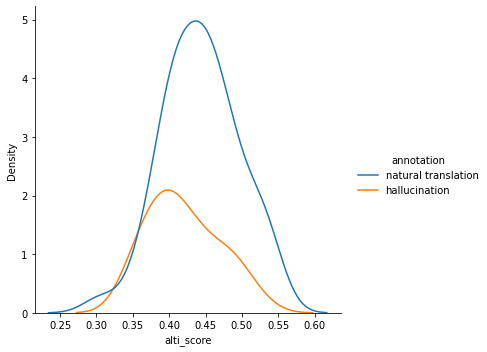

In [40]:
# detection based on the scores distribution

sns.displot(df_new, x="sent_score", kind="kde", hue="annotation")
plt.axvline(-1.09, 0,1.25, color='red')
plt.show()

sns.displot(df_new, x="laser_score", kind="kde", hue="annotation")
plt.axvline(0.778, 0,8, color='red')
plt.show()

sns.displot(df_new, x="alti_score", kind="kde", hue="annotation")
plt.show()


false negatives
Siminoff yavuze ko ibicuruzwa byazamutse nyuma yo kugaragara mu mwaka wa 2013 mu gice cya Shark Tank aho abagenzuzi b'igitaramo banze gutanga inkunga yo gutangira.
Ishyirahamwe ry'imikino ya Gymnastics muri Leta Zunze Ubumwe z'Amerika (USA Gymnastics) n'Ishyirahamwe ry'imikino ya Olympic muri Amerika (USOC) bifite intego imwe, ni ukuvuga gutuma imikino y'imikino ya Gymnastics n'indi mikino itari iy'imikino itari iy'imikino itari iy'imikino itari iy'imikino itari iy'imikino itari iy'imikino itari iy'imikino itari iy'imikino itari iy'imikino.
Ibindi bihembo birimo Best Picture, Director, Cinematography, Costume Design, Film-editing, Original Score, Production Design, Sound Editing, Sound Mixing na Original Screenplay.
Basanze izuba rikora hakurikijwe amahame amwe n'ay'izindi nyenyeri.
Ntiyatangaje umubare w'abazacibwa, avuga ko bazacibwa hashingiwe ku iterambere ry'ubukungu bw'Ubushinwa.
Robin Uthappa yatsinze ibitego byinshi kurusha abandi, 70 mu mikino 41 gusa mu gutsin

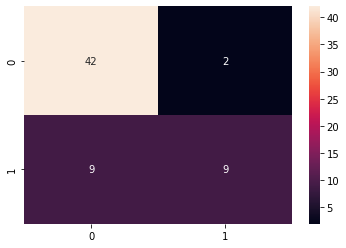

In [45]:
# detection based on the sent score distribution

def sent_dist_based_detection(df, threshold=-1):
    #halluc=1
    #natural_trans=0

    orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])]
    pred_classes = []
    
    for i,score in enumerate(df["sent_score"]):
        if score <= threshold:
            pred_classes.append(1)
        else:
            pred_classes.append(0)

    # check false negatives
    print("false negatives")
    for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
        print(df["kin"][j]) 

    print("--"*50)

    # check false positives
    print("false positives")
    for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
        print(df["kin"][j])

    f_score = f1_score(np.array(orig_classes), np.array(pred_classes))
    p_score = precision_score(np.array(orig_classes), np.array(pred_classes))
    r_score = recall_score(np.array(orig_classes), np.array(pred_classes))
    conf_matrix = confusion_matrix(orig_classes, pred_classes)
        
    return f_score, p_score, r_score, conf_matrix
  
f_score, p_score, r_score, conf_matrix = sent_dist_based_detection(df_new, threshold=-1.09)
print("\n", "f1_score:", f_score, "precision_score:", p_score, "recall_score:", r_score)

sns.heatmap(conf_matrix, annot=True)
plt.show()

false negatives
Siminoff yavuze ko ibicuruzwa byazamutse nyuma yo kugaragara mu mwaka wa 2013 mu gice cya Shark Tank aho abagenzuzi b'igitaramo banze gutanga inkunga yo gutangira.
Ishyirahamwe ry'imikino y'ibinyabiziga muri Leta Zunze Ubumwe z'Amerika (USA Gymnastics) ryashyigikiye ko hakorwa iperereza rifite ubwigenge rigamije kureba uko abantu barokotse urupfu rwa Larry Nassar bashobora kuba baragize ubutwari bwo gusebanya ku rugero rwagaragajwe n'abari barokotse.
Ishyirahamwe ry'imikino ya Gymnastics muri Leta Zunze Ubumwe z'Amerika (USA Gymnastics) n'Ishyirahamwe ry'imikino ya Olympic muri Amerika (USOC) bifite intego imwe, ni ukuvuga gutuma imikino y'imikino ya Gymnastics n'indi mikino itari iy'imikino itari iy'imikino itari iy'imikino itari iy'imikino itari iy'imikino itari iy'imikino itari iy'imikino itari iy'imikino itari iy'imikino.
Ibindi bihembo birimo Best Picture, Director, Cinematography, Costume Design, Film-editing, Original Score, Production Design, Sound Editing, Soun

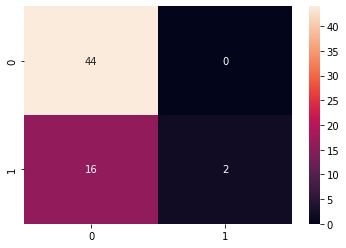

In [47]:
# detection based on the laser score distribution

def laser_dist_based_detection(df, threshold=-1):
    #halluc=1
    #natural_trans=0

    orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])]
    pred_classes = []
    
    for i,score in enumerate(df["laser_score"]):
        if score <= threshold:
            pred_classes.append(1)
        else:
            pred_classes.append(0)

    # check false negatives
    print("false negatives")
    for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
        print(df["kin"][j]) 

    print("--"*50)

    # check false positives
    print("false positives")
    for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
        print(df["kin"][j])

    f_score = f1_score(np.array(orig_classes), np.array(pred_classes))
    p_score = precision_score(np.array(orig_classes), np.array(pred_classes))
    r_score = recall_score(np.array(orig_classes), np.array(pred_classes))
    conf_matrix = confusion_matrix(orig_classes, pred_classes)
        
    return f_score, p_score, r_score, conf_matrix
  
f_score, p_score, r_score, conf_matrix = laser_dist_based_detection(df_new, threshold=0.778)
print("\n", "f1_score:", f_score, "precision_score:", p_score, "recall_score:", r_score)

sns.heatmap(conf_matrix, annot=True)
plt.show()

false negatives
Siminoff yavuze ko ibicuruzwa byazamutse nyuma yo kugaragara mu mwaka wa 2013 mu gice cya Shark Tank aho abagenzuzi b'igitaramo banze gutanga inkunga yo gutangira.
Ishyirahamwe ry'imikino ya Gymnastics muri Leta Zunze Ubumwe z'Amerika (USA Gymnastics) n'Ishyirahamwe ry'imikino ya Olympic muri Amerika (USOC) bifite intego imwe, ni ukuvuga gutuma imikino y'imikino ya Gymnastics n'indi mikino itari iy'imikino itari iy'imikino itari iy'imikino itari iy'imikino itari iy'imikino itari iy'imikino itari iy'imikino itari iy'imikino itari iy'imikino.
Ibindi bihembo birimo Best Picture, Director, Cinematography, Costume Design, Film-editing, Original Score, Production Design, Sound Editing, Sound Mixing na Original Screenplay.
Ntiyatangaje umubare w'abazacibwa, avuga ko bazacibwa hashingiwe ku iterambere ry'ubukungu bw'Ubushinwa.
Robin Uthappa yatsinze ibitego byinshi kurusha abandi, 70 mu mikino 41 gusa mu gutsinda ibitego 11 bya 4 na 2 bya 6.
Icyicaro cya cyenda, cyabonye imyuzu

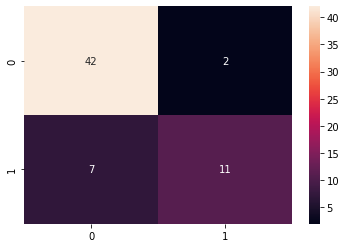

In [50]:
# detection based on the laser score distribution

def sent_laser_dist_based_detection(df, sent_threshold=-1, laser_threshold=0.7):
    #halluc=1
    #natural_trans=0

    orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])]
    pred_classes = []
    
    for i in range(len(df)):
        if df["sent_score"][i] < sent_threshold or df["laser_score"][i] < laser_threshold:
            pred_classes.append(1)
        else:
            pred_classes.append(0)

    # check false negatives
    print("false negatives")
    for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
        print(df["kin"][j]) 

    print("--"*50)

    # check false positives
    print("false positives")
    for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
        print(df["kin"][j])

    f_score = f1_score(np.array(orig_classes), np.array(pred_classes))
    p_score = precision_score(np.array(orig_classes), np.array(pred_classes))
    r_score = recall_score(np.array(orig_classes), np.array(pred_classes))
    conf_matrix = confusion_matrix(orig_classes, pred_classes)
        
    return f_score, p_score, r_score, conf_matrix
  
f_score, p_score, r_score, conf_matrix = sent_laser_dist_based_detection(df_new, sent_threshold=-1.09, laser_threshold=0.778)
print("\n", "f1_score:", f_score, "precision_score:", p_score, "recall_score:", r_score)

sns.heatmap(conf_matrix, annot=True)
plt.show()

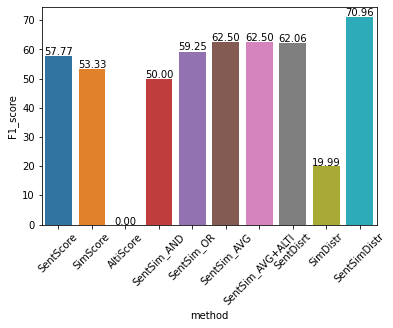

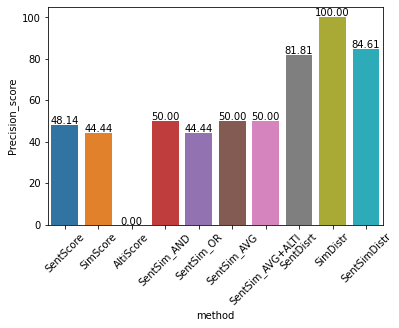

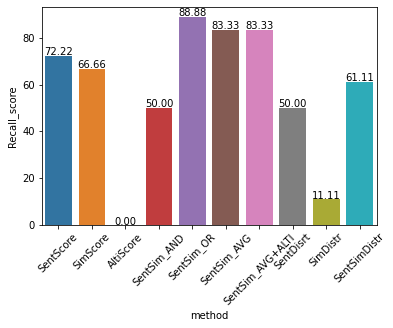

In [62]:
# results comparizon

def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.0075)
                value = '{:.2f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.2f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
        
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

df_plot = pd.DataFrame({"method":["SentScore", "SimScore", "AltiScore", "SentSim_AND", "SentSim_OR", "SentSim_AVG", "SentSim_AVG+ALTI", "SentDisrt", "SimDistr", "SentSimDistr"],
                  "F1_score":[57.77, 53.33, 0.00, 50.00, 59.25, 62.50, 62.50, 62.06, 19.99, 70.96],
                  "Precision_score":[48.14, 44.44, 0.00, 50.00, 44.44, 50, 50, 81.81, 100.00, 84.61],
                  "Recall_score":[72.22, 66.66, 0.00, 50.00, 88.88, 83.33, 83.33, 50.00, 11.11, 61.11]})

ax_f1 = sns.barplot(x = 'method',
            y = 'F1_score',
#             hue = 'method',
            data = df_plot,
            estimator = np.median,
            ci = 0)
show_values(ax_f1)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
# change_width(ax_f1, .50)
plt.show()

ax_precision = sns.barplot(x = 'method',
            y = 'Precision_score',
#             hue = 'method',
            data = df_plot,
            estimator = np.median,
            ci = 0)
show_values(ax_precision)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

ax_recall = sns.barplot(x = 'method',
            y = 'Recall_score',
#             hue = 'method',
            data = df_plot,
            estimator = np.median,
            ci = 0)
show_values(ax_recall)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

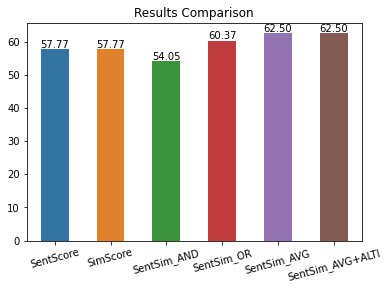

In [56]:
# compare the results

df_table = pd.DataFrame({"SentScore":[57.77], "SimScore":[57.77], "SentSim_AND":[54.05], "SentSim_OR":[60.37], "SentSim_AVG":[62.5], "SentSim_AVG+ALTI":[62.5]})
#  , "SentSim_AND":[54.05], "SentSim_OR":60.37, "SentSim_AVG":62.50
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.0075)
                value = '{:.2f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.2f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
# who v/s fare barplot
ax = sns.barplot(data = df_table,
            estimator = np.median,
            ci = 0)

change_width(ax, .50)
show_values(ax)

plt.title("Results Comparison")

# plt.figure(figsize = (15,8))
# plt.rcParams["figure.figsize"]=14,5

locs, labels = plt.xticks()
plt.setp(labels, rotation=15)

# plt.savefig("annotation/alti-res2.png",format='png',dpi=150)
# Show the plot
plt.show()



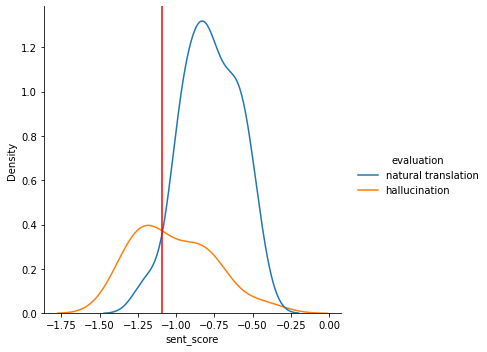

In [33]:
import pandas as pd
# import plotext as plt
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("annotation/kin_fs_hallucination_eval.csv")
cond = df["annotation"]=="ww"
cond_hl = (df["annotation"]=="DH") | (df["annotation"]=="OH") | (df["annotation"]=="EH") | (df["annotation"]=="SH")
cond_nt = df["annotation"]=="NT"

df.loc[cond,"annotation"]="WW"
df.loc[cond_hl,"annotation"]="hallucination"
df.loc[cond_nt,"annotation"]="natural translation"
df_new = df[df["annotation"]!="WW"]


sns.displot(df_new, x="sent_score", kind="kde", hue="annotation")

plt.axvline(-1.09, 0,1.25, color='red')

# plt.title("eng-kin eng-kin sentence scores distribution")

plt.savefig("sent_score_distribution.png",
                    format='png',dpi=150)

plt.show()


0.6206896551724137


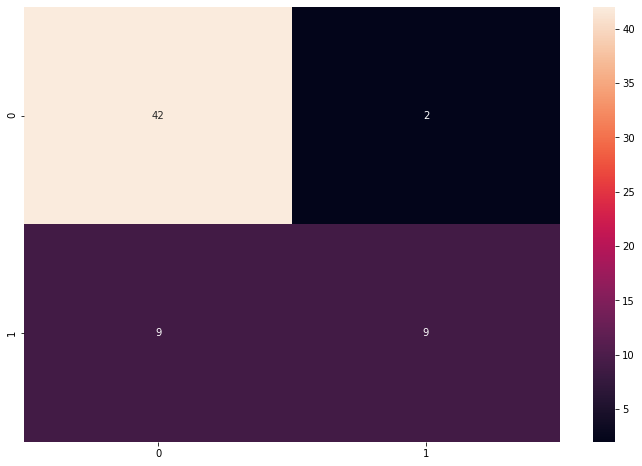

In [128]:
# classifying based on the probability distribution
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def dist_based_classification(df, threshold=-1):
        #halluc=1
        #natural_trans=0
        orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])]
        pred_classes = []
        for i,score in enumerate(df["sent_score"]):
            if score <= threshold:
                pred_classes.append(1)
            else:
                pred_classes.append(0)
                
        f1 = f1_score(np.array(orig_classes), np.array(pred_classes))
        conf_matrix = confusion_matrix(orig_classes, pred_classes)
        return f1, conf_matrix
    
f_score, conf_matrix = dist_based_classification(df_new, threshold=-1.09)
print(f_score)

sns.heatmap(conf_matrix, annot=True)
plt.show()

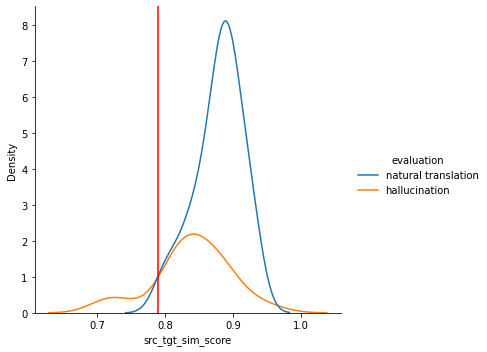

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("annotation/kin_fs_hallucination_eval.csv")
cond = df["annotation"]=="ww"
cond_hl = (df["annotation"]=="DH") | (df["annotation"]=="OH") | (df["annotation"]=="EH") | (df["annotation"]=="SH")
cond_nt = df["annotation"]=="NT"

df.loc[cond,"annotation"]="WW"
df.loc[cond_hl,"annotation"]="hallucination"
df.loc[cond_nt,"annotation"]="natural translation"
df_new = df[df["annotation"]!="WW"]


sns.displot(df_new, x="laser_score", kind="kde", hue="annotation")
plt.axvline(0.79, 0,8, color='red')
plt.rcParams["figure.figsize"]=12,8
# plt.title("eng-kin similarity scores distribution")
plt.savefig("laser_score_distribution.png",
                    format='png',dpi=200)
plt.show()

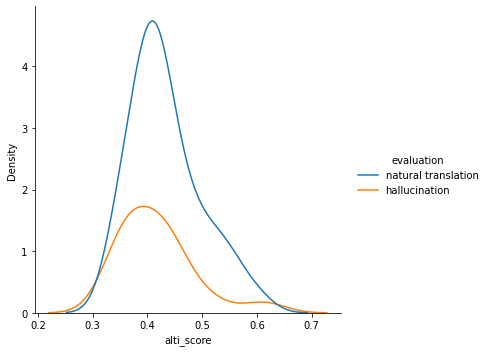

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("annotation/kin_fs_hallucination_eval.csv")
cond = df["annotation"]=="ww"
cond_hl = (df["annotation"]=="DH") | (df["annotation"]=="OH") | (df["annotation"]=="EH") | (df["annotation"]=="SH")
cond_nt = df["annotation"]=="NT"

df.loc[cond,"annotation"]="WW"
df.loc[cond_hl,"annotation"]="hallucination"
df.loc[cond_nt,"annotation"]="natural translation"
df_new = df[df["annotation"]!="WW"]


sns.displot(df_new, x="alti_score", kind="kde", hue="annotation")
# plt.axvline(0.79, 0,8, color='red')
plt.rcParams["figure.figsize"]=12,8
# plt.title("eng-kin similarity scores distribution")
plt.savefig("alti_score_distribution.png",
                    format='png',dpi=200)
plt.show()

0.19999999999999998


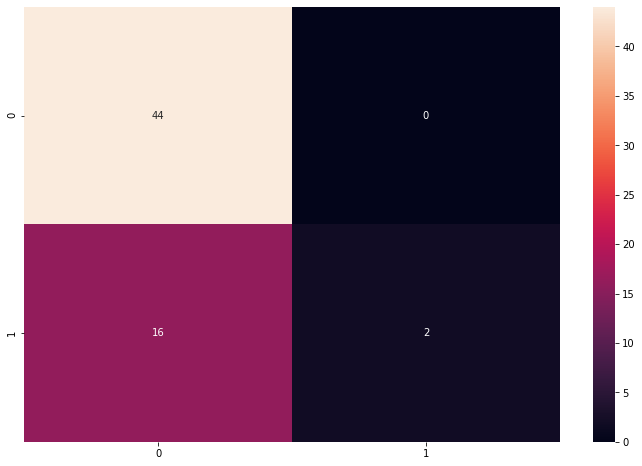

In [131]:
# classifying based on the similarity score
import numpy as np
from sklearn.metrics import f1_score

def sim_based_classification(df, threshold=-1):
        #halluc=1
        #natural_trans=0
        orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])]
        pred_classes = []
        for i,score in enumerate(df["laser_score"]):
            if score <= threshold:
                pred_classes.append(1)
            else:
                pred_classes.append(0)
        
        f1 = f1_score(np.array(orig_classes), np.array(pred_classes))
        conf_matrix = confusion_matrix(orig_classes, pred_classes)
        return f1, conf_matrix
    
f_score, conf_matrix = sim_based_classification(df_new, threshold=0.79)
print(f_score)

sns.heatmap(conf_matrix, annot=True)
plt.show()

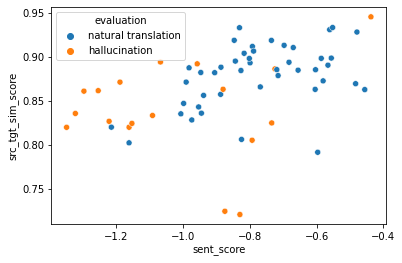

In [12]:
sns.scatterplot(data=df_new, x="sent_score", y="laser_score", hue="annotation")
plt.savefig("annotation/sent_sim_correlation.png",
                     format='png',dpi=150)
plt.show()

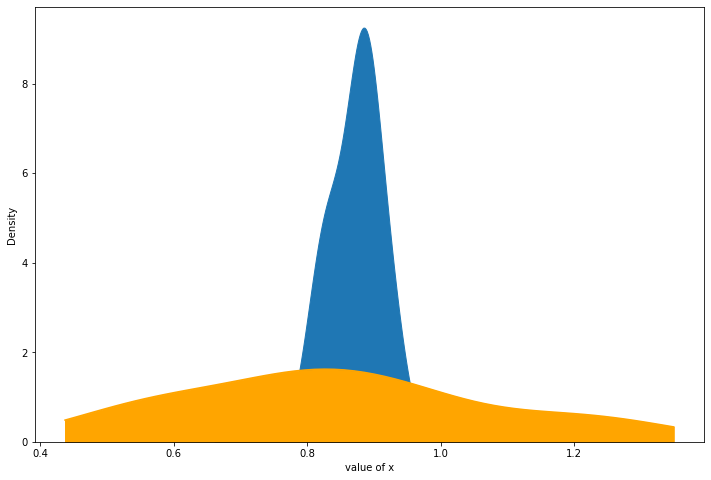

In [25]:
# libraries
import numpy as np
from numpy import linspace
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

df = pd.read_csv("annotation/kin_fs_hallucination_eval.csv")
cond = df["annotation"]=="ww"
cond_hl = (df["annotation"]=="DH") | (df["annotation"]=="OH") | (df["annotation"]=="EH") | (df["annotation"]=="SH")
cond_nt = df["annotation"]=="NT"

df.loc[cond,"annotation"]="WW"
df.loc[cond_hl,"annotation"]="hallucination"
df.loc[cond_nt,"annotation"]="natural translation"
df_new = df[df["annotation"]!="WW"]

# Fig size
plt.rcParams["figure.figsize"]=12,8

# plot density chart for var1
sns.kdeplot(data=df_new, x="laser_score",  fill=True, alpha=1)

# plot density chart for var2
kde = gaussian_kde(df_new.sent_score)
x_range = linspace(min(df_new.sent_score), max(df_new.sent_score), len(df_new.sent_score))

# multiply by -1 to reverse axis (mirror plot)
sns.lineplot(x=x_range*-1, y=kde(x_range) * 1, color='orange') 
plt.fill_between(x_range*-1, kde(x_range) * 1, color='orange')

# add axis names        
plt.xlabel("value of x")
plt.axhline(y=0, linestyle='-',linewidth=1, color='black')



# show the graph
plt.show()

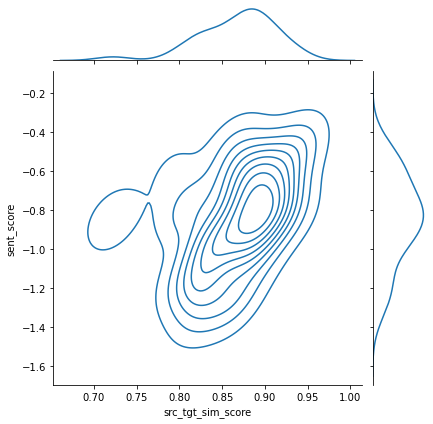

In [24]:
sns.jointplot(
    data=df_new,
    x="laser_score", y="sent_score",
    kind="kde"
)

plt.show()

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0]
Ibyo byagezweho kandi bitumenyesha ukuntu amababa y'inyoni yahindutse.
Icyo itsinda ry'abashakashatsi ryashakaga kumenya, ni uko ibyo bintu byaturukaga ku bintu by'umwijima biri hagati y'iyo mibumbe y'inyenyeri ya Milky Way.
----------------------------------------------------------------------------------------------------
Siminoff yavuze ko ibicuruzwa byazamutse nyuma yo kugaragara mu mwaka wa 2013 mu gice cya Shark Tank aho abagenzuzi b'igitaramo banze gutanga inkunga yo gutangira.
Ishyirahamwe ry'imikino ya Gymnastics muri Leta Zunze Ubumwe z'Amerika (USA Gymnastics) n'Ishyirahamwe ry'imikino ya Olympic muri Amerik

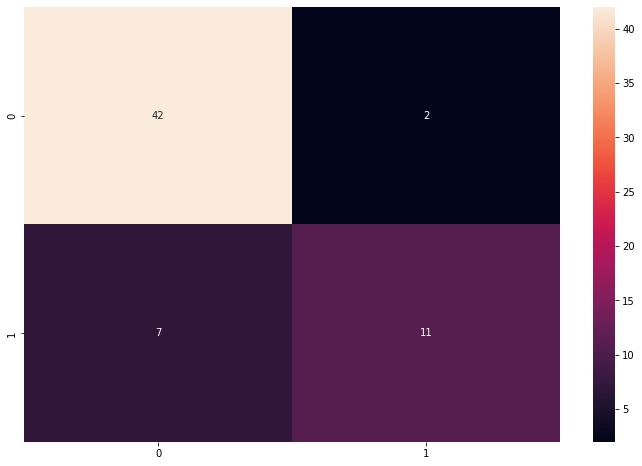

In [39]:
# classifying based on both sentence and similarity scores
import numpy as np
from sklearn.metrics import f1_score

def sim_dist_based_classification(df, sim_threshold=-1, dist_threshold=-1):
        #halluc=1
        #natural_trans=0
        df = df.reset_index(drop=True)
        orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])]
        pred_classes = []
        for i in range(len(df)):
            if df["laser_score"][i] < sim_threshold or df["sent_score"][i] < dist_threshold:
                pred_classes.append(1)
            else:
                pred_classes.append(0)
        
        print(pred_classes)
        print(orig_classes)
#         print([i for i, v in enumerate(pred_classes) if v==1])
#         for j in [i for i, v in enumerate(pred_classes) if v==1]:
#             print(df["kin"][j])
        for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
            print(df["kin"][j])
        print("--"*50)
        for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
            print(df["kin"][j])
        
        f1 = f1_score(np.array(orig_classes), np.array(pred_classes))
        conf_matrix = confusion_matrix(orig_classes, pred_classes)
        
        return f1, conf_matrix

f_score, conf_matrix = sim_dist_based_classification(df_new, sim_threshold=0.79, dist_threshold=-1.09)
print(f_score)

sns.heatmap(conf_matrix, annot=True)
plt.savefig("sent_sim_distribution_conf_matrix.png",
                    format='png',dpi=150)
plt.show()


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0]
----------------------------------------------------------------------------------------------------
Siminoff yavuze ko ibicuruzwa byazamutse nyuma yo kugaragara mu mwaka wa 2013 mu gice cya Shark Tank aho abagenzuzi b'igitaramo banze gutanga inkunga yo gutangira.
Ishyirahamwe ry'imikino y'ibinyabiziga muri Leta Zunze Ubumwe z'Amerika (USA Gymnastics) ryashyigikiye ko hakorwa iperereza rifite ubwigenge rigamije kureba uko abantu barokotse urupfu rwa Larry Nassar bashobora kuba baragize ubutwari bwo gusebanya ku rugero rwagaragajwe n'abari barokotse.
Ishyirahamwe ry'imikino ya Gymnastics muri Leta Zunze Ubumwe z'Amerika

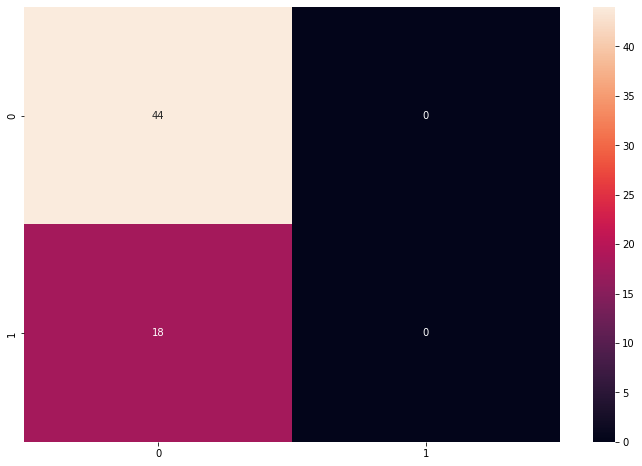

In [38]:
# classifying based on both sentence and similarity scores
import numpy as np
from sklearn.metrics import f1_score

def sim_dist_based_classification(df, sim_threshold=-1, dist_threshold=-1):
        #halluc=1
        #natural_trans=0
        df = df.reset_index(drop=True)
        orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])]
        pred_classes = []
        for i in range(len(df)):
            if (df["laser_score"][i] + sim_threshold or df["sent_score"][i]) <= (dist_threshold+sim_threshold):
                pred_classes.append(1)
            else:
                pred_classes.append(0)
        
        print(pred_classes)
        print(orig_classes)
#         print([i for i, v in enumerate(pred_classes) if v==1])
#         for j in [i for i, v in enumerate(pred_classes) if v==1]:
#             print(df["kin"][j])
        for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
            print(df["kin"][j])
        print("--"*50)
        for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
            print(df["kin"][j])
        
        f1 = f1_score(np.array(orig_classes), np.array(pred_classes))
        conf_matrix = confusion_matrix(orig_classes, pred_classes)
        
        return f1, conf_matrix

f_score, conf_matrix = sim_dist_based_classification(df_new, sim_threshold=0.79, dist_threshold=-1.09)
print(f_score)

sns.heatmap(conf_matrix, annot=True)
plt.savefig("sent_sim_distribution_conf_matrix_sum.png",
                    format='png',dpi=150)
plt.show()


In [37]:
import numpy as np
import pandas as pd

def sent_sim_cand_ratio(df):
    sent_score = []
    laser_score = []
    n_true = 0
    n_false = 0
    for i in range(len(df)):
        sent_score.append(df.beam_score[i])
        laser_score.append(df.laser_score[i])
        if ((i+1)%4)==0:
            best_cand_sent_score_pos = np.argmax(np.array(sent_score))
            best_cand_laser_score_pos = np.argmax(np.array(laser_score))
            if best_cand_sent_score_pos==best_cand_laser_score_pos:
                print(df.label[i], df.beam_cand[i])
                n_true += 1
            else:
                n_false += 1
            sent_score = []
            laser_score = []
        else:
            continue
    return ((4*n_true)/len(df))*100, ((4*n_false)/len(df))*100

beam_df = pd.read_csv("annotation/beam_cand.csv")
ratio_true, ratio_false = sent_sim_cand_ratio(beam_df)
print(ratio_true, ratio_false)

ww Yongeyeho ati "ubu dufite impene z'amezi ane zitagira diyabete zari zifite diyabeti".
ww Dr. Ehud Ur, umwarimu wigisha ibijyanye n'ubuvuzi muri Kaminuza ya Dalhousie i Halifax muri Nouvelle-Écosse, akaba n'umuyobozi w'ishami ry'ubuvuzi n'ubuhanga mu bya siyansi ry'Ishyirahamwe ry'Abanduye Icyorezo cya Diyabete ryo muri Kanada, yatanze umuburo w'uko ubushakashatsi bugikomeza.
nt Kimwe n'abandi bahanga, na we ntiyemera ko indwara y'igisukari ishobora gukira, kandi avuga ko ibyo bashyize ahagaragara bitagira icyo bimarira abantu bafite indwara y'igisukari yo mu bwoko bwa 1.
nt N'ubwo urukingo rumwe rukiri mu igeragezwa rwerekana ko rushobora kugabanya umubare w'abahitanwa na Ebola, kugeza ubu nta miti yagaragaye neza ko ishobora kuvura ubwandu buriho.
ww Kimwe mu bikoresho by'imiti irwanya ubwandu, ZMapp, mu ntangiriro cyagaragaye ko ari cyiza, ariko ubushakashatsi bwakozwe bwagaragaje ko nta ngaruka byatanze mu kwirinda urupfu.
ww Mu igerageza rya PALM, ZMapp yakoreshejwe nk'uburyo bw

In [22]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def sim_sent_avg_based_classification(df):
    sent_laser_scores = [df.sent_score[i]+df.laser_score[i] for i in range(len(df))] # if df.annotation[i]=="natural translation"
    sent_sim_avg = np.array(sent_laser_scores).sum()/len(sent_laser_scores)
    print(sent_sim_avg)

    #orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])]
    pred_classes = []
    n_hl = 0
    n_nt = 0
    for i in range(len(df)):
        if df["sent_score"][i]+df["laser_score"][i] <= sent_sim_avg:
            pred_classes.append(1)
            n_hl += 1
        else:
            pred_classes.append(0)
            n_nt += 1

#         print(pred_classes)
#         print(orig_classes)
#         #print([i for i, v in enumerate(pred_classes) if v==1])
#         for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
#             print(df["kin"][j])
#         print("--"*50)
#         for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
#             print(df["kin"][j])

#         f1 = f1_score(np.array(orig_classes), np.array(pred_classes))
#         conf_matrix = confusion_matrix(orig_classes, pred_classes)

    return n_hl, n_nt

fs_umb = pd.read_csv("annotation/eng-umb-scores.csv")   
n_hl, n_nt = sim_sent_avg_based_classification(fs_umb)
print(n_hl, n_nt)

# sns.heatmap(conf_matrix, annot=True)
# plt.savefig("annotation/sent_sim_correlation_avg.png",
#                      format='png',dpi=150)
# plt.show()

0.07620444630306324
483 529


0.9111111111111111


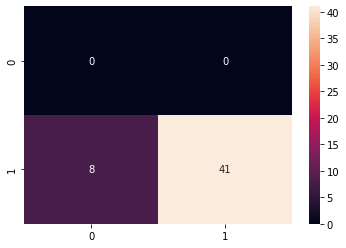

In [21]:
# classifying based on the average natural sentence score
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def cat_avg_based_classification(df, avg_score):
        #halluc=1
        #natural_trans=0

        orig_classes = [1]*len(df)
        pred_classes = []
        for i,score in enumerate(df["sent_score"]):
            if score <= avg_score:
                pred_classes.append(1)
            else:
                pred_classes.append(0)
                
#         for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
#             print(df["kin"][j])
#         print("--"*50)
#         for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
#             print(df["kin"][j])
                
        f1 = f1_score(np.array(orig_classes), np.array(pred_classes))
        conf_matrix = confusion_matrix(orig_classes, pred_classes)
        return f1, conf_matrix 
    
sent_score_avg = -0.8478348091564517  
df_cat = pd.read_csv("annotation/catastrophic/wol-eng.csv")    
f_score, conf_matrix = cat_avg_based_classification(df_cat, sent_score_avg)
print(f_score)

sns.heatmap(conf_matrix, annot=True)
# plt.savefig("annotation/avg_sent_score-based.png",
#                      format='png',dpi=150)
plt.show()

0.9896907216494846


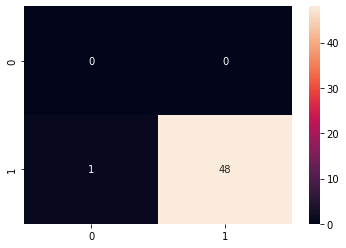

In [22]:
# classifying based on the average natural sentence score
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def cat_sim_avg_based_classification(df, avg_score):
        #halluc=1
        #natural_trans=0

        orig_classes = [1]*len(df)
        pred_classes = []
        for i,score in enumerate(df["laser_score_nllb200"]):
            if score <= avg_score:
                pred_classes.append(1)
            else:
                pred_classes.append(0)
                
#         for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
#             print(df["kin"][j])
#         print("--"*50)
#         for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
#             print(df["kin"][j])
                
        f1 = f1_score(np.array(orig_classes), np.array(pred_classes))
        conf_matrix = confusion_matrix(orig_classes, pred_classes)
        return f1, conf_matrix 
    
laser_score_avg = 0.867173569032258  
df_cat = pd.read_csv("annotation/catastrophic/wol-eng.csv")    
f_score, conf_matrix = cat_sim_avg_based_classification(df_cat, laser_score_avg)
print(f_score)

sns.heatmap(conf_matrix, annot=True)
# plt.savefig("annotation/avg_sent_score-based.png",
#                      format='png',dpi=150)
plt.show()

F1 score for wol-eng hallucination detection
1.0


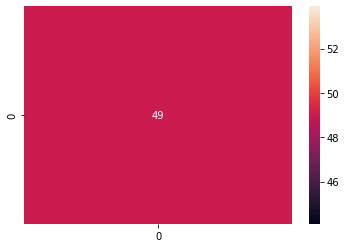

F1 score for ibo-eng hallucination detection
1.0


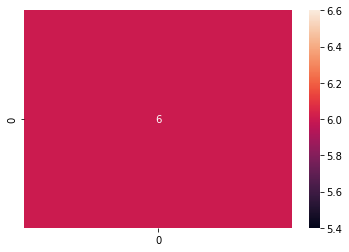

F1 score for kam-eng hallucination detection
1.0


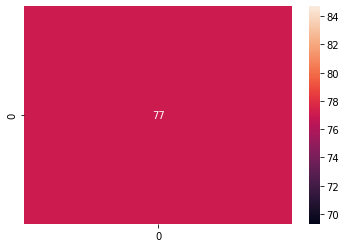

F1 score for luo-eng hallucination detection
1.0


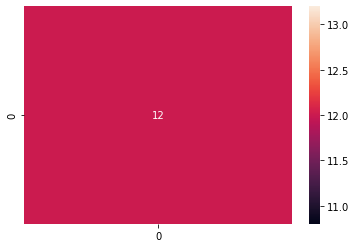

F1 score for orm-eng hallucination detection
1.0


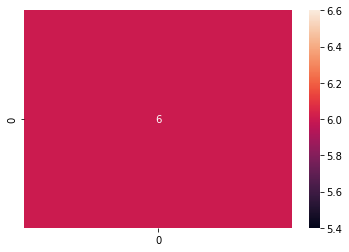

F1 score for som-eng hallucination detection
1.0


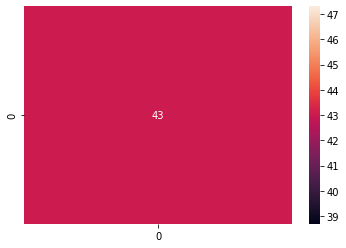

F1 score for yor-eng hallucination detection
1.0


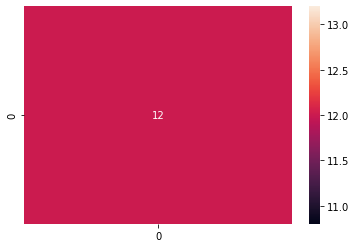

In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def sim_sent_avg_based_classification(df, sent_sim_avg):
        #halluc=1
        #natural_trans=0
        orig_classes = [1]*len(df)
        pred_classes = []
        
        
        for i in range(len(df)):
            if df["laser_score_orig"][i]+df["sent_score_orig"][i] <= sent_sim_avg:
                pred_classes.append(1)
            else:
                pred_classes.append(0)
        
#         print(pred_classes)
#         print(orig_classes)
#         #print([i for i, v in enumerate(pred_classes) if v==1])
#         for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
#             print(df["kin"][j])
#         print("--"*50)
#         for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
#             print(df["kin"][j])
        
        f1 = f1_score(np.array(orig_classes), np.array(pred_classes))
        conf_matrix = confusion_matrix(orig_classes, pred_classes)
        
        return f1, conf_matrix

sent_sim_avg = 0.01933875987580646
srcs = ['wol', 'ibo', 'kam', 'luo', 'orm', 'som', 'yor']
tgt = 'eng'
for src in srcs:
    df_cat = pd.read_csv(f"annotation/catastrophic/{src}-{tgt}-balanced-eval.csv")
    if len(df_cat) >= 5:
        print(f"F1 score for {src}-{tgt} hallucination detection")
        f_score, conf_matrix = sim_sent_avg_based_classification(df_cat, sent_sim_avg)
        print(f_score)

        sns.heatmap(conf_matrix, annot=True)
        # plt.savefig("annotation/sent_sim_correlation_avg.png",
        #                      format='png',dpi=150)
        plt.show()
    else:
        continue

F1 score for wol-eng hallucination detection
0.8735632183908045 1.0 0.7755102040816326


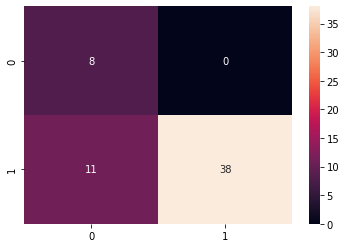

F1 score for ibo-eng hallucination detection
0.6666666666666666 1.0 0.5


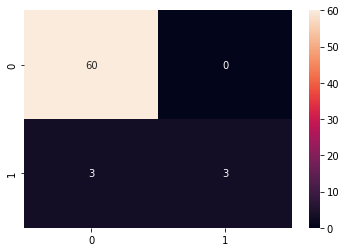

F1 score for kam-eng hallucination detection
0.8062015503875969 1.0 0.6753246753246753


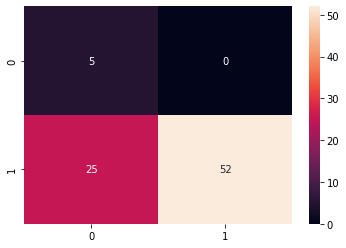

F1 score for luo-eng hallucination detection
0.6666666666666666 1.0 0.5


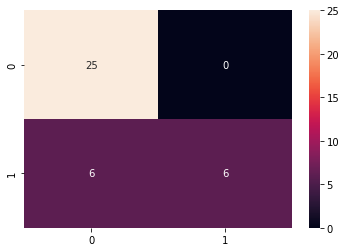

F1 score for orm-eng hallucination detection
0.6666666666666666 1.0 0.5


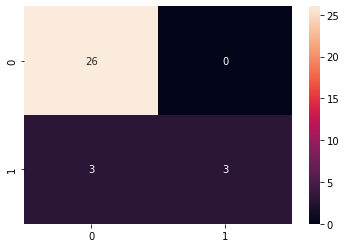

F1 score for som-eng hallucination detection
0.7352941176470588 1.0 0.5813953488372093


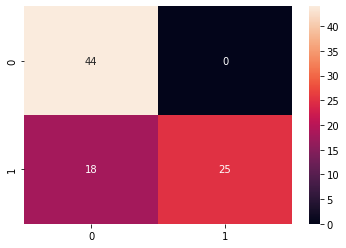

F1 score for yor-eng hallucination detection
1.0 1.0 1.0


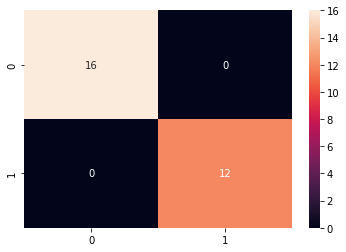

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

def alti_based_classification(df, alti_threshold):
        #halluc=1
        #natural_trans=0
        orig_classes = [1 if eval=="catastrophic" else 0 for i,eval in enumerate(df["annotation"])]
        pred_classes = []  
        
        for i in range(len(df)):
            if df["alti_score"][i] <= alti_threshold:
                pred_classes.append(1)
            else:
                pred_classes.append(0)
        
#         print(pred_classes)
#         print(orig_classes)
#         #print([i for i, v in enumerate(pred_classes) if v==1])
#         for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
#             print(df["kin"][j])
#         print("--"*50)
#         for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
#             print(df["kin"][j])
        
        f1 = f1_score(np.array(orig_classes), np.array(pred_classes))
        conf_matrix = confusion_matrix(orig_classes, pred_classes)
        p_score = precision_score(np.array(orig_classes), np.array(pred_classes))
        r_score = recall_score(np.array(orig_classes), np.array(pred_classes))
        
        return f1, conf_matrix, p_score, r_score

alti_threshold = 0.3
srcs = ['wol', 'ibo', 'kam', 'luo', 'orm', 'som', 'yor']
tgt = 'eng'
for src in srcs:
    df_cat = pd.read_csv(f"annotation/catastrophic/{src}-{tgt}-balanced-eval.csv")
    if len(df_cat) >= 5:
        print(f"F1 score for {src}-{tgt} hallucination detection")
        f_score, conf_matrix, p_score, r_score = alti_based_classification(df_cat, alti_threshold)
        print(f_score, p_score, r_score)

        sns.heatmap(conf_matrix, annot=True)
        # plt.savefig("annotation/sent_sim_correlation_avg.png",
        #                      format='png',dpi=150)
        plt.show()
    else:
        continue

F1 score for wol-eng hallucination detection
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
0.9702970297029703 0.9423076923076923


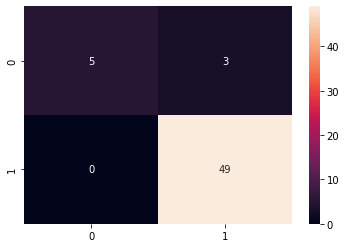

F1 score for ibo-eng hallucination detection
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1]
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.4799999999999999 0.3157894736842105


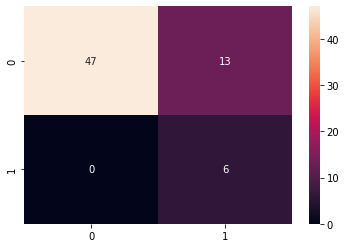

F1 score for kam-eng hallucination detection
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
0.9871794871794872 0.9746835443037974


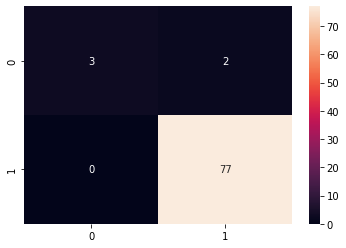

F1 score for luo-eng hallucination detection
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.8571428571428571 0.75


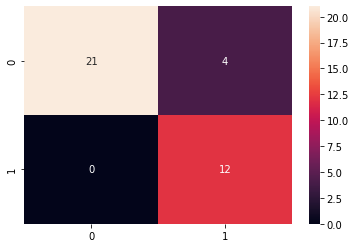

F1 score for orm-eng hallucination detection
[1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.41379310344827586 0.2608695652173913


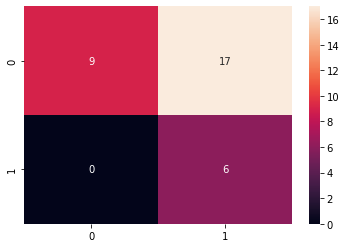

F1 score for som-eng hallucination detection
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.9052631578947368 0.8269230769230769


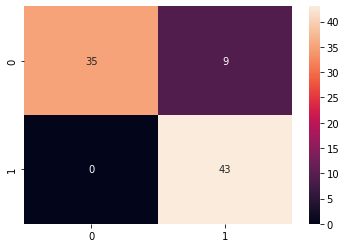

F1 score for yor-eng hallucination detection
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.888888888888889 0.8


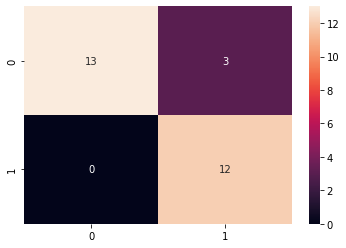

In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

def sim_sent_alti_based_classification(df, sent_sim_avg, alti_threshold):
        #halluc=1
        #natural_trans=0
        orig_classes = [1 if eval=="catastrophic" else 0 for i,eval in enumerate(df["annotation"])]
        pred_classes = []
        
        
        for i in range(len(df)):
            if (df["laser_score"][i]+df["sent_score"][i]) <= sent_sim_avg:
                pred_classes.append(1)
            else:
                pred_classes.append(0)
        
        print(pred_classes)
        print(orig_classes)
#         #print([i for i, v in enumerate(pred_classes) if v==1])
#         for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
#             print(df["kin"][j])
#         print("--"*50)
#         for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
#             print(df["kin"][j])
        
        f1 = f1_score(np.array(orig_classes), np.array(pred_classes))
        conf_matrix = confusion_matrix(orig_classes, pred_classes)
        precision = precision_score(np.array(orig_classes), np.array(pred_classes))
        
        return f1, conf_matrix, precision

sent_sim_avg = 0.01933875987580646
alti_threshold = 0.3
srcs = ['wol', 'ibo', 'kam', 'luo', 'orm', 'som', 'yor']
tgt = 'eng'
for src in srcs:
    df_cat = pd.read_csv(f"annotation/catastrophic/{src}-{tgt}-balanced-eval.csv")
    if len(df_cat) >= 5:
        print(f"F1 score for {src}-{tgt} hallucination detection")
        f_score, conf_matrix, p_score = sim_sent_alti_based_classification(df_cat, sent_sim_avg, alti_threshold)
        print(f_score, p_score)

        sns.heatmap(conf_matrix, annot=True)
        # plt.savefig("annotation/sent_sim_correlation_avg.png",
        #                      format='png',dpi=150)
        plt.show()
    else: 97.02, 47.99, 98.71, 85.71, 41.73, 90.52, 88.88
        continue

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

def score_distribution_based_classification(df, sent_threshold, sim_threshold):
        #halluc=1
        #natural_trans=0
        orig_classes = [1 if eval=="catastrophic" else 0 for i,eval in enumerate(df["annotation"])]
        pred_classes = []
        
        
        for i in range(len(df)):
            if (df["laser_score"][i] < sim_threshold or df["sent_score"][i] < sent_threshold) or df["alti_score"]<=0.3:
                pred_classes.append(1)
            else:
                print
                pred_classes.append(0)
        
        print(pred_classes)
        print(orig_classes)
#         #print([i for i, v in enumerate(pred_classes) if v==1])
#         for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
#             print(df["kin"][j])
#         print("--"*50)
#         for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
#             print(df["kin"][j])
        
        f1 = f1_score(np.array(orig_classes), np.array(pred_classes))
        conf_matrix = confusion_matrix(orig_classes, pred_classes)
        precision = precision_score(np.array(orig_classes), np.array(pred_classes))
        
        return f1, conf_matrix, precision

sent_threshold = -1.09
sim_threshold = 0.79
alti_threshold = 0.3
srcs = ['wol', 'ibo', 'kam', 'luo', 'orm', 'som', 'yor']
tgt = 'eng'
for src in srcs:
    df_cat = pd.read_csv(f"annotation/catastrophic/{src}-{tgt}-balanced-eval.csv")
    if len(df_cat) >= 5:
        print(f"F1 score for {src}-{tgt} hallucination detection")
        f_score, conf_matrix, p_score = score_distribution_based_classification(df_cat, sent_threshold, sim_threshold)
        print(f_score, p_score)

        sns.heatmap(conf_matrix, annot=True)
        # plt.savefig("annotation/sent_sim_correlation_avg.png",
        #                      format='png',dpi=150)
        plt.show()
    else:
        continue

F1 score for wol-eng hallucination detection


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

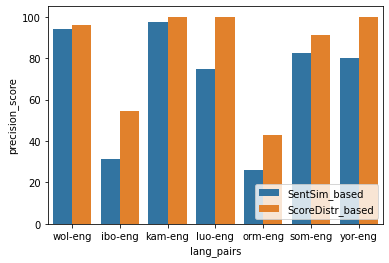

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

df = pd.DataFrame({"method":["SentSim_based", "SentSim_based", "SentSim_based", "SentSim_based", "SentSim_based", "SentSim_based", "SentSim_based", "ScoreDistr_based", "ScoreDistr_based", "ScoreDistr_based", "ScoreDistr_based", "ScoreDistr_based", "ScoreDistr_based", "ScoreDistr_based"],
                  "lang_pairs":["wol-eng", "ibo-eng", "kam-eng", "luo-eng", "orm-eng", "som-eng", "yor-eng", "wol-eng", "ibo-eng", "kam-eng", "luo-eng", "orm-eng", "som-eng", "yor-eng"], 
                  "precision_score":[94.23, 31.57, 97.46, 75.00, 26.08, 82.69, 80, 96.07,54.54, 100, 100, 42.85, 91.4, 100],
                  "F1_score":[97.02, 47.99, 98.71, 85.71, 41.73, 90.52, 88.88, 98.00,70.58, 100, 100, 60.00, 95.5, 100]})

sns.barplot(x = 'lang_pairs',
            y = 'precision_score',
            hue = 'method',
            data = df,
            estimator = np.median,
            ci = 0)

# for i in ax.containers:
#     ax.bar_label(i,)
# Change the legend position
plt.legend(loc='lower right')

plt.savefig("annotation/sent_sim_and_distr_comparison.png",
                             format='png',dpi=300)
# Show the plot
plt.show()


In [36]:
import numpy as np
lst = [2,3,1,4]
np.argsort(np.array(lst))

array([2, 0, 1, 3])

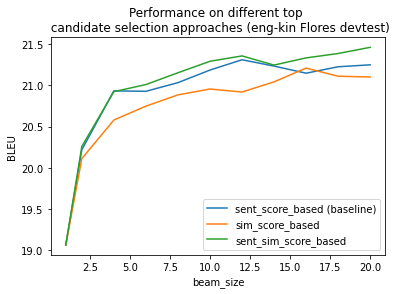

In [97]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("annotation/beam_rerank_comp_kin.csv")
beam_size = df["beam_size"]
plt.plot(df["beam_size"], df["Beam_base"], label="sent_score_based (baseline)")
plt.plot(df["beam_size"], df["Beam_sim"], label="laser_score_based")
plt.plot(df["beam_size"], df["Beam_sent_sim"], label="sent_laser_score_based")
plt.title("Performance on different top \n candidate selection approaches (eng-kin Flores devtest)")
plt.xlabel("beam_size")
plt.ylabel("BLEU")
plt.legend()
plt.rcParams["figure.figsize"]=6,4
plt.savefig("annotation/beam-rerank-kin.png",
                             format='png',dpi=150)
plt.show()

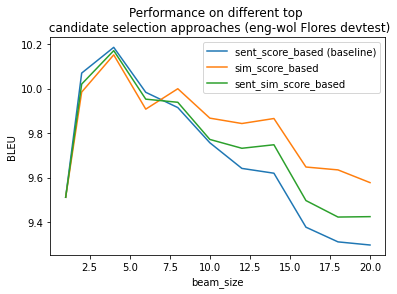

In [96]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("annotation/eng-wol-beam-rerank.csv")
beam_size = df["beam_size"]
plt.plot(df["beam_size"], df["sent_score"], label="sent_score_based (baseline)")
plt.plot(df["beam_size"], df["laser_score"], label="laser_score_based")
plt.plot(df["beam_size"], df["sent_sim"], label="sent_laser_score_based")
plt.title("Performance on different top \n candidate selection approaches (eng-wol Flores devtest)")
plt.xlabel("beam_size")
plt.ylabel("BLEU")
plt.legend()
plt.savefig("annotation/beam-rerank-wol.png",
                             format='png',dpi=150)
plt.show()

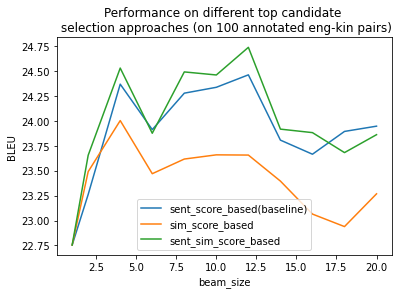

In [4]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("annotation/beam-rerank-kin-100.csv")
beam_size = df["beam_size"]
plt.plot(df["beam_size"], df["sent_score"], label="sent_score_based(baseline)")
plt.plot(df["beam_size"], df["laser_score"], label="laser_score_based")
plt.plot(df["beam_size"], df["sent_laser_score"], label="sent_laser_score_based")
plt.title("Performance on different top candidate \n selection approaches (on 100 annotated eng-kin pairs)")
plt.xlabel("beam_size")
plt.ylabel("BLEU")
plt.legend()
plt.savefig("annotation/beam-rerank-kin-100.png",
                             format='png',dpi=150)
plt.show()

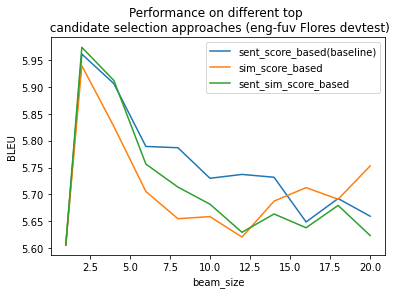

In [99]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("annotation/beam-rerank-fuv.csv")
beam_size = df["beam_size"]
plt.plot(df["beam_size"], df["sent_score"], label="sent_score_based(baseline)")
plt.plot(df["beam_size"], df["laser_score"], label="laser_score_based")
plt.plot(df["beam_size"], df["sent_laser_score"], label="sent_laser_score_based")
plt.title("Performance on different top \n candidate selection approaches (eng-fuv Flores devtest)")
plt.xlabel("beam_size")
plt.ylabel("BLEU")
plt.legend()
plt.savefig("annotation/beam-rerank-fuv.png",
                             format='png',dpi=150)
plt.show()

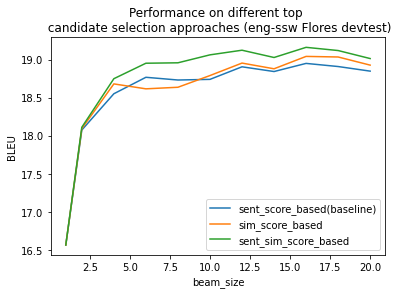

In [2]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("annotation/beam-rerank-ssw.csv")
beam_size = df["beam_size"]
plt.plot(df["beam_size"], df["sent_score"], label="sent_score_based(baseline)")
plt.plot(df["beam_size"], df["laser_score"], label="laser_score_based")
plt.plot(df["beam_size"], df["sent_laser_score"], label="sent_laser_score_based")
plt.title("Performance on different top \n candidate selection approaches (eng-ssw Flores devtest)")
plt.xlabel("beam_size")
plt.ylabel("BLEU")
plt.legend()
plt.savefig("annotation/beam-rerank-ssw.png",
                             format='png',dpi=150)
plt.show()

True